<a href="https://colab.research.google.com/github/cikufa/lateralcontrol_1/blob/main/terminate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# libraries
#saarhin
#tasks: 1-action , preview dist in in reward/ 2- one step ahead in network input/ 3- reward every 5 iteration 
import numpy as np 
import math
import matplotlib.pyplot as plt
import shapely.geometry as geom
from shapely.ops import nearest_points
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import adam_v2
import tensorflow_probability as tfp
import os
from keras.layers import Dense
!pip install xlsxwriter
import xlsxwriter
#from keras.optimizers import adam
from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 149 kB 5.0 MB/s 
Mounted at /content/drive


In [3]:
class GenericNetwork(keras.Model):
    def __init__(self, n_actions, fc1_dims, fc2_dims, name, chkpt_dir="/tmp/actor_critic"):
        super(GenericNetwork, self).__init__()
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.model_name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name)

        self.fc1 = Dense(self.fc1_dims, activation='relu')
        self.fc2 = Dense(self.fc2_dims, activation='relu')
        self.fc3 = Dense(n_actions)
        
        #self.v = Dense(1, activation=None)
        #continous action is represented as a normal distribution that is characterized with 2 quantities: a mean and a standard deviation 
        #self.pi = Dense(n_actions=2, activation='softmax')

    def call(self, state):
        x = self.fc1(state)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [4]:
class Agent:
    def __init__(self, layer1_dim=128, layer2_dim=64, n_actions=2, alpha_A=0.00003, alpha_C=0.00005, gamma=0.99):
        self.layer1_dim = layer1_dim
        self.layer2_dim = layer2_dim
        self.n_actions = n_actions
        self.gamma = gamma
        self.alpha_A = alpha_A 
        self.alpha_C= alpha_C
        self.action = None
        self.log_prob= None
        
        self.actor = GenericNetwork(n_actions, layer1_dim, layer2_dim, "actor")
        self.actor.compile(optimizer=adam_v2.Adam(learning_rate=alpha_A))
        self.critic = GenericNetwork(1, layer1_dim, layer2_dim, "critic")
        self.critic.compile(optimizer=adam_v2.Adam(learning_rate=alpha_C))
        self.aloss= []
        self.closs=[]

    def choose_action(self, observation): #obs shape (1,2)
        state = tf.convert_to_tensor([observation]) #state shape (1,1,2)
        pars= self.actor(state) #mean and standard deviation that make action probs
        pars= np.asarray(tf.squeeze(pars)).reshape(1,2)  
        sigma , mu = np.hsplit(pars , 2)
        sigma = tf.exp(sigma) #get rid of negative sigma
        #sigma= abs(sigma)
        action_probabilities = tfp.distributions.Normal(mu , sigma) #normal distribution with mu,sigma pars  
        #log_prob = action_probabilities.log_prob(action_probabilities) #log (gonna be used for gradient)
        action = action_probabilities.sample() #choose action (most likely to be chosen with higher probability)
        action = tf.tanh(action) * 0.07 #action: continuous num in range(-0.07, 0.07)((-4,4) degree_
        self.action = action  
        return action #cast tensor to numpy(openAI gym doesnt take tensor)

    # def save_models(self):
    #     #print('... saving models ...')
    #     self.actor.save_weights(self.actor.checkpoint_file)
    #     self.critic.save_weights(self.critic.checkpoint_file)
    # def load_models(self):
    #     print('... loading models ...')
    #     self.actor.load_weights(self.actor.checkpoint_file)
    #     self.critic.load_weights(self.critic.checkpoint_file)
        
    def learn(self, state, reward, state_,done):
        #print("state before ")
        state = tf.convert_to_tensor([state], dtype=tf.float32)
        state_ = tf.convert_to_tensor([state_], dtype=tf.float32)
        reward = tf.convert_to_tensor(reward, dtype=tf.float32) # not fed to NN -> no need to reshape
        with tf.GradientTape(persistent=True) as tape:
            state_value = self.critic(state)
            state_value_ = self.critic(state_)
            state_value = tf.squeeze(state_value) #squeeze Removes dims of size 1 from the shape of a tensor.
            state_value_ = tf.squeeze(state_value_)
            pars= self.actor(state)
            #pars= np.asarray(tf.squeeze(pars)).reshape(1,2)
            #mu , sigma= np.hsplit(pars , 2)
            #mu = np.squeeze(mu)
            #sigma = np.squeeze(sigma)
            mu = pars[0,0]
            sigma = pars[0,1]
            #print(sigma)
            #sigma = tf.exp(sigma)
            #print(sigma)
            action_probs = tfp.distributions.Normal(mu, abs(sigma)) #policy 
            log_prob = action_probs.log_prob(self.action[0,0] )
            #print(mu,sigma)
            #print(log_prob)
                      
            #TD error: 
            TD= self.gamma*state_value_*(1-int(done)) - state_value 
            delta = reward + TD #1-done: terminal stRemoves dimensions of size 1 from the shape of a tensor.ate zero effect 
            actor_loss = (-log_prob*delta)            
            critic_loss = (delta**2) 
            #print("sig", sigma , "ac", actor_loss, "cr", critic_loss)
  
            
        gradient1 = tape.gradient(actor_loss, self.actor.trainable_variables)
        
        self.actor.optimizer.apply_gradients((grad , var) for (grad , var) in zip(gradient1, self.actor.trainable_variables) if grad is not None)
        #if grad is not None
            
        gradient2 = tape.gradient(critic_loss, self.critic.trainable_variables)
        self.critic.optimizer.apply_gradients((grad , var) for (grad , var) in zip(gradient2, self.critic.trainable_variables) if grad is not None)
        # if grad is not None
        return critic_loss, actor_loss, gradient1


In [142]:
import matplotlib.pyplot as plt
import numpy as np
import shapely.geometry as geom
from shapely.ops import nearest_points
import math


class lateralenv:
    def __init__(self, data, data_length, n_episodes, episode_length):
        # constants
        dt = 0.01
        vx = 10
        iz = 2278.8
        m = 1300
        a1 = 1;
        a2 = 1.5
        caf = 60000
        car = 60000
        cb = -(caf + car);
        cr = (-a1 * caf + a2 * car) / vx
        db = -(a1 * caf - a2 * car);
        dr = -(a1 ** 2 * caf + a2 ** 2 * car) / vx
        cd = caf;
        dd = a1 * caf
        self.constants = [dt, vx, iz, m, cb, cr, db, dr, cd, dd]

        self.data_length = data_length
        self.n_episodes = n_episodes
        self.episode_length = episode_length
        self.episode_length_cnt = episode_length

        self.road = data[0:data_length, :]
        self.x = data[0:data_length, 0]
        self.y = data[0:data_length, 1]
        self.data_ep = []

        self.heading_angle = [np.arctan2(self.y[i + 1] - self.y[i], self.x[i + 1] - self.x[i]) for i in
                              range(self.data_length - 1)]  # rad [-1.57, 1.57]
        self.heading_angle.insert(0, self.heading_angle[0])  # append last value to adjust the shape
        self.heading_angle = np.asfarray(self.heading_angle).reshape(self.data_length, 1)

        # ______________________________________________init vars_____________________________________________________________

        self.score = 0
        self.index = 0
        self.Done = 0
        self.coordinates = []
        self.inds=[]
        self.nearestPiontCheck = []
        self.vys = []
        self.vymax = -10
        self.vars = np.zeros((5, 1))
        self.vars_ = np.zeros((5, 1), dtype='float64')  # is only updated for normal step
        self.vars_tmp = np.zeros((5, 1))  # is updated for both normal step and preview step

    # ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

        self.n_episodes = 100
        self.max_ep_length = 300  # could be int(data_length / n_episodes)

        self.cnt = 0
        self.dist_limit = 5
        self.ang_limit1 = 0.79;
        self.ang_limit2 = -0.79;  # 45 degree
        self.bad_reward = 10
        self.res = 8
        self.b = 0  # for render
        self.score_history = []
        self.best_score = 0  # reward = 1/positive > 0 -> min score =0
        self.load_checkpoint = False

    def dist_diff(self, ep, limit_dist, limit_ang, stp):  # =geom.Point(0,0)):
        vy, r, x, y, psi = self.vars_tmp

        # 3: based on car's vertical disance with the road
        minus = self.data_ep - np.array((x, y)).reshape([1,2])
        distarr = np.sqrt(minus[:, 0] ** 2 + minus[:, 1] ** 2)
        ind = np.argmin(distarr)
        # if(len(ind)!=1):
        #   print("more than one argmin")
        #dist = np.min(distarr)
        road_slope = (self.data_ep[ind+1, 1] - self.data_ep[ind, 1])/(self.data_ep[ind+1, 0] - self.data_ep[ind, 0]) if ind!=len(self.data_ep)-1 else (self.data_ep[ind, 1] - self.data_ep[ind-1, 1])/(self.data_ep[ind, 0] - self.data_ep[ind-1, 0])

        point = geom.Point(x, y)
        dist = point.distance(self.road_ep)
        #dist2 = np.sqrt((self.data_ep[ind,0]-x) ** 2 + (self.data_ep[ind,1] - y) ** 2)
        #print(dist - dist2)
        limited_dist = max(dist, 0.01)  # for makhraj problems
        # limited_dist = min(limited_dist, 100)

        # dist_z = math.sqrt((y - self.y0) ** 2 + (x - self.x0) ** 2)

        nearestP = nearest_points(self.road_ep, point)[0]
        #self.nearestPiontCheck.append(np.array(nearestP))
        #self.nearestPiontCheck.append(np.array(point))
        #road_slope = (nearestP.y - pre_point.y) / (nearestP.x - pre_point.x) if (nearestP.x - pre_point.x) != 0 else (nearestP.y - pre_point.y) / 0.001
        diffs= road_slope - psi
        angle_diff = np.arctan2(diffs,  1)[0]
        limited_angle_diff= angle_diff
        # angle_diff = abs(np.arctan2((nearestP.y-pre_point.y),nearestP.x-pre_point.x)- psi[0]) #sara

        # index, = np.where(self.road_ep == nearestP)
        # print("index", index)
        # angle_diff=  np.arctan2(self.road_ep[index+1][1]-self.road_ep[index][1], self.road_ep[index+1][0]- self.road_ep[index][0]) - psi
        # angle_diff = abs((np.cos(x / 100) / 4 - psi)[0])
        # limited_angle_diff = max(angle_diff, 0.005)
        # limited_angle_diff=min(limited_angle_diff , 100) #-> max reward = 5000, min reward 5e-5

        if limit_dist == 1:
            if limit_ang == 1:
                return limited_dist, limited_angle_diff, nearestP, ind
            elif limit_ang == 0:
                return limited_dist, angle_diff, nearestP, ind
        else:
            return dist, angle_diff, nearestP, ind

    # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

    def preview(self, action,
                preview):  # in this version the preview point is calculated using the updated self.vars. also try with non-updated vars
        dt, vx, iz, m, cb, cr, db, dr, cd, dd = self.constants
        vy, r, x, y, psi = np.vsplit(self.vars, 5)
        if preview == 1:
            dt = 0.3
        if preview == 0:
            dt = 0.1
        # calc new state
        par_mat1 = np.array([[cb / (m * vx), cr / m - vx, 0, 0, 0],
                             [db / (iz * vx), dr / iz, 0, 0, 0],
                             [-math.sin(psi), 0, 0, 0, 0],
                             [math.cos(psi), 0, 0, 0, 0],
                             [0, 1, 0, 0, 0]])

        par_mat2 = np.array([[cd * action / m], [dd * action / iz], [vx * math.cos(psi)],
                             [vx * math.sin(psi)], [0]], dtype='float64')

        var_dot_mat = par_mat1 @ self.vars + par_mat2  # (5,1)= (5,5)@(5,1)+(5,1)
        self.vars_tmp = self.vars + dt * var_dot_mat  # (5,1) =(5,1)+(5,1)

        if preview == 0:
            self.vars_ = self.vars_tmp

        return

    # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    def normalize(self, d, a):
        # return d/(dist_limit-0), a/(ang_limit1-ang_limit2)
        return d / (self.dist_limit - 0), a

    def step(self, action, stp_cnt, pre_point, ep_length):
        self.preview(action, preview=0)
        # print("____________________________NOT preview_________________________")
        dist, angle_diff, pre_point, ind = lateralenv.dist_diff(self, ep=0, limit_dist=1, limit_ang=0, stp=stp_cnt)
        #print("in step", dist, angle_diff)
        # dist, angle_diff= self.normalize(d=dist, a=angle_diff)
        self.preview(action, preview=1)
        # print("____________________________preview______________________________")
        future_dist, future_angle_diff, _, _ = lateralenv.dist_diff(self, ep=0, limit_dist=1, limit_ang=0, stp=stp_cnt)
        # future_dist, future_angle_diff= self.normalize( d= future_dist, a=future_angle_diff)

        self.episode_length_cnt = self.episode_length_cnt - 1

        if dist > self.dist_limit or angle_diff > self.ang_limit1 or angle_diff < self.ang_limit2 or self.episode_length_cnt == 0:
            #print("141 step :  dist", dist, "angle", angle_diff)
            self.Done = 1
            # return self.vars_, self.state_,  bad_reward, 'nothing' , self.Done, pre_point
            return None, None, self.bad_reward, 'nothing', self.Done, None
        # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% calc reward %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

        # 3: based on car's vertical disance with the road
        else:
            dist, angle_diff = self.normalize(d=dist, a=angle_diff)
            future_dist, future_angle_diff = self.normalize(d=future_dist, a=future_angle_diff)
            weight = 1
            action_weight = -10
            preview_weight = 0.01
            # print("point", point, dist, "ang", angle_diff)
            # print("dist", dist, "ang", angle_diff)
            k1 = 1 / (dist ** 2 + angle_diff ** 2)
            k2 = 1 / (future_dist ** 2 + future_angle_diff ** 2)
            ep_len_weight = 1
            reward_calc = f'{weight} * {k1} + {preview_weight}*{k2} + {action_weight} * {action} + {ep_len_weight} * {ep_length}'
            # reward = - angle_diff

            ## 4: Sarah test
            # ------------------------
            reward = k1 * weight + k2 * preview_weight + action_weight * action + ep_len_weight * (
                        self.max_ep_length - self.episode_length_cnt)

            # print("dist", dist,"angd", angle_diff, "p dist",future_dist, "p angd", future_angle_diff)
            self.state_ = np.array([dist, angle_diff, future_dist, future_angle_diff])  # real state (not limited)
            # self.state_ = np.array([dist, angle_diff]) #real state (not limited)

            # for next step
            self.vars = self.vars_
            self.coordinates.append(self.vars[2:4, 0])
            self.inds.append(ind)
            self.vys.append(self.vars[0])

            return self.vars_, self.state_, reward, reward_calc, self.Done, pre_point  # state:(dist, ang_dif)

    # ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

    def render(self, ep, score, ep_length):
        print("render")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.plot(self.road_ep.coords.xy[0][:], self.road_ep.coords.xy[1][:], 'r')  # road
        if ep_length != 0:
            plt.plot(np.array(self.coordinates)[:, 0], np.array(self.coordinates)[:, 1], label=score)  # path
            # b=1
            if ep % 1 == 0:
              #plt.show()
              print("inds len ", len(self.inds))
              [print("22221115555", self.inds[i], "-->",  self.data_ep[self.inds[i]]) for i in range(len(self.inds))]
              plt.savefig(f"drive/MyDrive/RL_lane_following_debug/paths/path{ep}.jpg")
              plt.cla()
              b = 0

    def reset(self, ep_pointer):  # before each episode
        self.Done = 0
        self.episode_length_cnt = self.max_ep_length
        self.coordinates = []
        self.inds=[]
        self.nearestPiontCheck = []

        # a new section of the road excel is selected for each episode
        self.data_ep = self.road[ep_pointer:ep_pointer + int(self.max_ep_length / self.res), :]
        self.road_ep = geom.LineString(zip(self.x[ep_pointer: ep_pointer + int(self.max_ep_length / self.res)],
                                           self.y[ep_pointer: ep_pointer + int(self.max_ep_length / self.res)]))  # 500*2

        # the car starts on the road
        st_vy = 0;
        st_r = 0;
        st_x = self.data_ep[0, 0]  # + np.random.rand()
        # st_x = self.road[ep_pointer:ep_pointer+1,0]
        st_y = self.data_ep[0, 1]  # + np.random.rand()
        # st_y = self.road[ep_pointer+ep_pointer+1,1]
        # st_psi = self.heading_angle[ep_pointer]  # + np.random.rand()*0.01
        st_psi = (self.data_ep[1,1] - self.data_ep[0,1]) / (self.data_ep[1,0] - self.data_ep[0,0])
        st_pre_point = geom.Point(st_x, st_y)

        self.vars = np.array([[st_vy, st_r, st_x, st_y, st_psi]], dtype='float64').T
        self.vars_tmp = np.array([[st_vy, st_r, st_x, st_y, st_psi]],
                                 dtype='float64').T  # is updated for both normal step and preview step

        # point0_ep = geom.Point(st_x, st_y)
        limited_dist0, limited_angle_diff0, pre_p, ind = self.dist_diff(ep=0, limit_dist=1, limit_ang=0, stp=0)
        limited_dist0, limited_angle_diff0 = self.normalize(limited_dist0, limited_angle_diff0)

        self.preview(action=0, preview=1)
        future_limited_dist0, future_limited_ang0, _ , ind= self.dist_diff(ep=0, limit_dist=1, limit_ang=0, stp=0)  # sefr
        future_limited_dist0, future_limited_ang0 = self.normalize(future_limited_dist0, future_limited_ang0)

        state0_ep = np.array([limited_dist0, limited_angle_diff0, future_limited_dist0, future_limited_ang0])  # (1,4)

        return state0_ep, st_pre_point

In [144]:
import numpy as np
import matplotlib.pyplot as plt
#from Agent import Agent
#from lateralenv import lateralenv
import xlsxwriter
import warnings
import pandas as pd
import tensorflow as tf
import shapely.geometry as geom

warnings.filterwarnings("ignore")

# if __name__ == '__main__':
# discreate_road_pd = pd.read_csv('drive/MyDrive/RL_lane_following_debug/Chaos-generted road.csv')
discreate_road_pd = pd.read_csv('drive/MyDrive/RL_lane_following_debug/resroad.csv')

road = discreate_road_pd.to_numpy()

agent = Agent(layer1_dim=128, layer2_dim=64, n_actions=2, alpha_A=0.0003, alpha_C=0.005, gamma=0.99)
n_episodes = 1
data_length = int(road.shape[0] / 10)  # 10,000
max_ep_length = 300  # could be int(data_length / n_episodes)
env = lateralenv(road, data_length, n_episodes, max_ep_length)

cnt = 0
dist_limit = 5
ang_limit1 = 0.79;
ang_limit2 = -0.79;  # 45 degree
bad_reward = 10
res = 1
b = 0  # for render
score_history = []
best_score = 0  # reward = 1/positive > 0 -> min score =0
load_checkpoint = False

workbook = xlsxwriter.Workbook('drive/MyDrive/RL_lane_following_debug/log.xlsx')
log = workbook.add_worksheet("ep_per_ep")
log.write(0, 0, "ep / step")
log.write(0, 3, "vy")
log.write(0, 4, "point")
log.write(0, 5, "distance")
log.write(0, 6, "angle_diff")
log.write(0, 7, "road derivative")
log.write(0, 8, "psi")
log.write(0, 9, "reward")
log.write(0, 10, "point dist_diff +  preview point dist_diff + action")
log.write(0, 11, "action")


# training________________________________________________________________________________________
ep_pointer = 0
for ep in range(1, n_episodes + 1):
    score = 0
    al = [];
    cl = [];
    rewards = []
    # print("b4 reset")
    state, pre_point = env.reset(ep_pointer)  # (1,2)
    # print("after reset state", state)
    states_ = []
    ep_length = 0
    stp_cnt=0
    # print(ep, ":____________________________________________________________________________")
    while True:
        action = agent.choose_action(state)
        # assert action != act_buffer , "equal actions !!"
        # act_buffer = action

        newvars, state_, reward, reward_calc, Done, pre_point = env.step(action, ep_length, pre_point, ep_length)
        print("dist, ang diff", state_)
        if Done == 1:
            break
        # if ep_length >100:
        #   break
        else:
            states_.append(state_)
            reward = tf.get_static_value(reward)
            score = score + reward
            rewards.append(reward)

            # if not load_checkpoint:
            closs, aloss, grad1 = agent.learn(state, reward, state_, Done)
            
            state = state_
            ep_length += 1  # step counter

            # log
            log.write(ep_pointer + ep_length + 1, 0, f"{ep} / {ep_length}")
            log.write(ep_pointer + ep_length + 1, 3, newvars[0])
            log.write(ep_pointer + ep_length + 1, 4, str(newvars[2:4]))
            log.write(ep_pointer + ep_length + 1, 5, state_[0])
            log.write(ep_pointer + ep_length + 1, 6, state_[1])
            log.write(ep_pointer + ep_length + 1, 7, np.cos(newvars[2] / 200)[0] / 4)
            log.write(ep_pointer + ep_length + 1, 8, newvars[-1])
            log.write(ep_pointer + ep_length + 1, 9, reward)
            log.write(ep_pointer + ep_length + 1, 10, reward_calc)
            log.write(ep_pointer + ep_length + 1, 11, str(action))

            
    states_ = np.array(states_)
    score_history.append(score * ep_length / 100)  # ep length should affect score
    ep_pointer += max(int(ep_length / res), 1)

    avg_score = np.mean(score_history[-100:])
    if avg_score > best_score:
        best_score = avg_score
    if (ep % 1 == 0):
        print('episode', ep, 'ep length ', ep_length, 'score', score, 'avg_score', avg_score)
        env.render(ep, score, ep_length)

workbook.close()
print('closed')
if not load_checkpoint:
    ep = [i + 1 for i in range(n_episodes)]
    x = np.array(ep).reshape(n_episodes, 1)
    score_history = np.array(score_history).reshape(n_episodes, 1)
    plt.xlabel("episode")
    plt.ylabel("score")
    plt.plot(x, score_history)
    plt.savefig('scores.png')

ValueError: ignored

dot on path 1250 150
index 83 dot on road argmin [1299.76342786   60.23657214]
dor on road nearest (array('d', [1299.763427860728]), array('d', [60.23657213943434]))


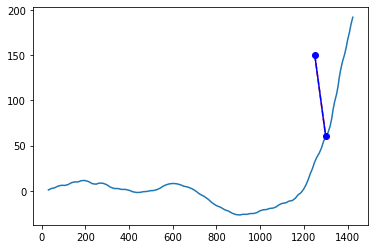

In [139]:
import pandas as pd
from google.colab import files
import io

#uploaded = 'drive/MyDrive/RL_lane_following_debug/Chaos-generted road.csv'
uploaded = 'drive/MyDrive/RL_lane_following_debug/resroad.csv'

road = pd.read_csv(uploaded).to_numpy()
road= road[0:100, :]
plt.plot(road[:,0],road[:,1])
# plt.show()
# plt.savefig('drive/MyDrive/RL_lane_following_debug/tets.png')
x= 1250; y=150
print("dot on path", x,y)
minusx = road[:,0] -x; minusy= road[:,1]-y
distarr = np.sqrt(minusx ** 2 + minusy ** 2)
ind = np.argmin(distarr)
print("index", ind, "dot on road argmin", road[ind, :])

xs=[x, road[ind,0]]
ys= [y, road[ind,1]]
plt.plot(xs, ys, 'r', linestyle="--")

p = geom.Point(x, y)
r= geom.LineString(road)
dist = p.distance(r)
nearestP = nearest_points(r, p)[0]
print("dor on road nearest", nearestP.coords.xy)
# print(nearestP.coords.xy[0][0])
xs2=[x, nearestP.coords.xy[0][0]]
ys2= [y, nearestP.coords.xy[1][0]]
plt.plot(xs2, ys2, 'bo', linestyle="-")
# import Geodataframe as df
# match_geom = df.loc[df.geometry== nearestP]
# print("dot on road geom", match_geom)


In [13]:
from google.colab import files
files.download('log.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Streaming output truncated to the last 5000 lines.
123
0.06291317254232955
124
0.06256192479556758
123
0.06291357316720353
123
0.06275624085248001
123
0.06259897328171182
122
0.06295312615588582
123
0.0625986641649596
123
0.06275551094166268
123
0.06291266859933067
123
0.06275602281131457
123
0.0625988702011499
123
0.06275635934434831
123
0.06259938299644557
122
0.06295371541875552
123
0.06259909163918195
123
0.06275659320569348
123
0.06291373995439399
124
0.0625617423511651
124
0.06271759874089772
124
0.06287390066333295
124
0.0627181044650159
124
0.06256232366544165
124
0.06271862269814817
124
0.06287483475828212
124
0.06303074372173738
125
0.0626806767405942
124
0.06303028715680534
125
0.06268070659134536
124
0.06303079769713804
125
0.06268068440631032
125
0.06283529946953058
125
0.06299031600914895
125
0.06283561850525439
125
0.06299081952590495
125
0.06283612207695842
125
0.06299127794615925
125
0.06283563591446728
125
0.06268046951387078
125
0.0628354490865022
125
0.0626800617165

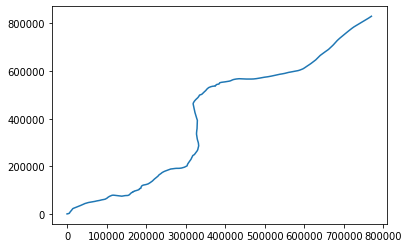

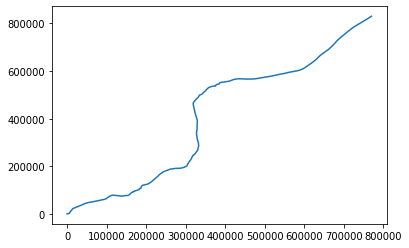

In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

discreate_road_pd = pd.read_csv('drive/MyDrive/RL_lane_following_debug/Chaos-generted road.csv')
discreate_road_np = discreate_road_pd.to_numpy()

x_acc = 0.06255
new_road =[]

for i in range(discreate_road_np.shape[0]-1):
    new_road.append(discreate_road_np[i,:])

    point_number = int(abs((discreate_road_np[i+1,0] - discreate_road_np[i,0])//x_acc))
    print(point_number)

    diff = (discreate_road_np[i+1,0] - discreate_road_np[i,0])/point_number
    print(diff)
    x = discreate_road_np[i,0]
    y = discreate_road_np[i,1]
    for j in range(point_number-1):
        x += diff
        y += ((discreate_road_np[i+1,1]-discreate_road_np[i,1])/(discreate_road_np[i+1,0]-discreate_road_np[i,0]))*diff
        new_road.append([x,y])

new_road = np.array(new_road)
plt.plot(discreate_road_np[:,0], discreate_road_np[:,1])
plt.show()
plt.cla()
plt.plot(new_road[:,0], new_road[:,1])
plt.show()

pd.DataFrame(new_road).to_csv('drive/MyDrive/RL_lane_following_debug/resroad.csv')